In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


**1. Import các thư viện cần thiết**

In [2]:
# 1. Các thư viện cần thiết
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression

**2. Đọc file dữ liệu VPB và chia dataset theo tỉ lệ 6:3:1**

In [3]:
# Đọc file dữ liệu
df = pd.read_csv('/content/drive/MyDrive/StockData/VPB.csv')
df = df[['Price']]
df = df.dropna() # Drop missing values
df = df.reset_index(drop=True) # Reset the index

# Split the data into training, testing, and validation
train_size = int(0.6 * len(df))
test_size = int(0.3 * len(df))
val_size = len(df) - train_size - test_size

train_data = df[:train_size]
test_data = df[train_size:train_size+test_size]
val_data = df[train_size+test_size:]

**Xem** **lại** **dataset**

In [4]:
df

,Price
0,10676.9
1,10687.7
2,10698.5
3,11195.6
4,11498.2
...,...
1246,19450.0
1247,19300.0
1248,19400.0
1249,19850.0


**3. Dùng model ARIMA để train data**

In [5]:
!pip install pmdarima

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 32.5 MB/s eta 0:00:00


In [6]:
# Quá trình Training
x_train = np.array(train_data.index).reshape(-1, 1)
y_train = np.array(train_data['Price'])

from pmdarima.arima import auto_arima
model = auto_arima(y_train, trace=True, error_action='ignore', suppress_warnings=True, seasonal = False)
# Fit the model
model.fit(y_train)

Performing stepwise search to minimize aic
 ARIMA(2,2,2)(0,0,0)[0] intercept   : AIC=10293.343, Time=4.10 sec
 ARIMA(0,2,0)(0,0,0)[0] intercept   : AIC=10692.678, Time=0.11 sec
 ARIMA(1,2,0)(0,0,0)[0] intercept   : AIC=10524.827, Time=0.10 sec
 ARIMA(0,2,1)(0,0,0)[0] intercept   : AIC=10302.234, Time=1.48 sec
 ARIMA(0,2,0)(0,0,0)[0]             : AIC=10690.682, Time=0.02 sec
 ARIMA(1,2,2)(0,0,0)[0] intercept   : AIC=inf, Time=2.42 sec
 ARIMA(2,2,1)(0,0,0)[0] intercept   : AIC=inf, Time=2.18 sec
 ARIMA(3,2,2)(0,0,0)[0] intercept   : AIC=10293.956, Time=3.10 sec
 ARIMA(2,2,3)(0,0,0)[0] intercept   : AIC=10288.720, Time=9.45 sec
 ARIMA(1,2,3)(0,0,0)[0] intercept   : AIC=10291.895, Time=5.34 sec
 ARIMA(3,2,3)(0,0,0)[0] intercept   : AIC=inf, Time=7.15 sec
 ARIMA(2,2,4)(0,0,0)[0] intercept   : AIC=inf, Time=2.40 sec
 ARIMA(1,2,4)(0,0,0)[0] intercept   : AIC=inf, Time=2.12 sec
 ARIMA(3,2,4)(0,0,0)[0] intercept   : AIC=inf, Time=2.77 sec
 ARIMA(2,2,3)(0,0,0)[0]             : AIC=10287.380, Ti

ARIMA(order=(2, 2, 4), scoring_args={}, suppress_warnings=True,
      with_intercept=False)

**4. Quá trình test**

In [7]:
x_test = np.array(test_data.index).reshape(-1, 1)
y_test = np.array(test_data['Price'])
y_pred = model.predict(n_periods=len(y_test))


**5. Quá trình validate**

In [8]:
x_val= np.array(val_data.index).reshape(-1, 1)
y_val = np.array(val_data['Price'])
y_pred_val =  model.predict(n_periods=len(y_val))

**6. Quá trình tạo index predict 30 ngày tiếp theo**

In [9]:
last_index =  df.index[-1]
last_data = pd.RangeIndex(start=last_index, stop=last_index+30, step=1)

# Create an array of 30 consecutive integers starting from last_index
x_next_30_days = np.array(range(last_index+1, last_index+31)).reshape(-1, 1)

# Predict the closing prices for the next 30 days
y_next_30_days = model.predict(n_periods=len(x_next_30_days))

# Print the predicted closing prices for the next 30 days
print('Predicted closing prices for the next 30 days:')
print(y_next_30_days)

Predicted closing prices for the next 30 days:
[26154.26765749 26256.63220246 26388.28948066 26541.55334436
 26669.94153501 26779.84460749 26910.87188553 27057.7132397
 27186.61649243 27301.99120136 27432.59812513 27574.77799788
 27704.0236558  27823.36959372 27953.69818966 28092.49492096
 28221.96630166 28344.19434352 28474.34034233 28610.68183685
 28740.30051418 28864.62012114 28994.64767083 29129.20742811
 29258.92102271 29384.75841446 29514.71020502 29647.97704424
 29777.75083399 29904.68957759]


***7.Đánh giá độ chính xác thuật toán***

In [10]:
#RMSE
valid_rmse = np.sqrt(np.mean((y_pred_val - y_val)**2))
test_rmse = np.sqrt(np.mean((y_pred - y_test)**2))
print('Validation RMSE:', valid_rmse)
print('Testing RMSE:', test_rmse)

#MAPE
valid_mape = np.mean(np.abs((y_val - y_pred_val) / y_val)) * 100
test_mape = np.mean(np.abs((y_test - y_pred) / y_test)) * 100
print('Validation MAPE:', valid_mape)
print('Testing MAPE:', test_mape)

#MAE
valid_mae = np.mean(np.abs(y_pred_val - y_val))
test_mae = np.mean(np.abs(y_pred - y_test))
print('Validation MAE:', valid_mae)
print('Testing MAE:', test_mae)

Validation RMSE: 15895.817016020317
Testing RMSE: 32841.378507484565
Validation MAPE: 81.2351300006348
Testing MAPE: 141.47190811043438
Validation MAE: 15380.621961039287
Testing MAE: 28355.8806262351


**8. Vẽ biểu đồ**

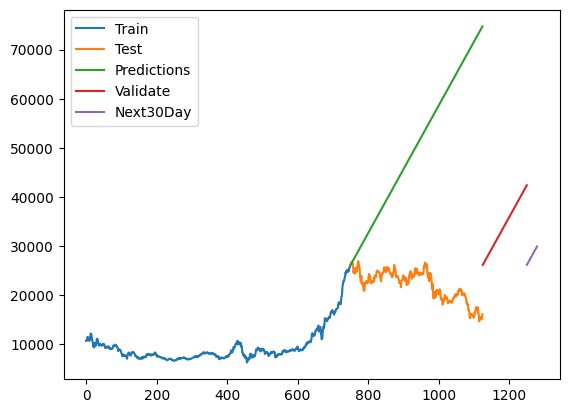

In [11]:
plt.plot(train_data.index, train_data['Price'])
plt.plot(test_data.index, test_data['Price'])
plt.plot(test_data.index, y_pred)
plt.plot(val_data.index, y_pred_val)
plt.plot(last_data,y_next_30_days)
plt.legend(['Train', 'Test', 'Predictions','Validate','Next30Day'])
plt.show()